# Modelling and fitting two unresolved emission lines with a bayesian approach

We will show how to model a spectrum with two superimposed lines and then try to retrieve the modelling parameters. this example is based on the preliminary examples :

1. [Modelling and fitting one emission line](./script_example_model+fit_1_line.ipynb)
2. [Modelling and fitting two resolved emission lines](./script_example_model+fit_2_lines.ipynb)

In [1]:
# inline plotting for jupyter notebook. Do not put this line in a real python script.
%matplotlib inline

In [2]:
import orb.fit
import pylab as pl
import numpy as np
from orb.core import Lines

## Third step: modelling and fitting a spectrum with two unresolved lines (classic fit and bayesian fit)

Now the two lines are set to nearly the same velocity but the other parameters are unchanged.

### Model

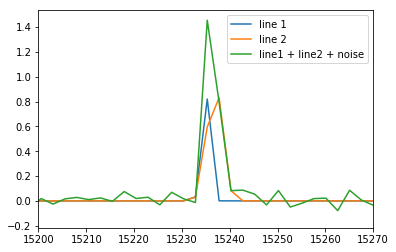

In [7]:
halpha_cm1 = Lines().get_line_cm1('Halpha')

nm_laser = 543.5
step = 2943
order = 8
resolution = 5000
theta = 15.5
axis_corr = 1. / np.cos(np.deg2rad(theta))

# model spectrum
velocity1 = 50
broadening1 = 15
spectrum1 = orb.fit.create_cm1_lines_model([halpha_cm1], [1], step, order, resolution, theta, fmodel='sincgauss',
                                         sigma=broadening1, vel=velocity1)

velocity2 = 10
broadening2 = 30
spectrum2 = orb.fit.create_cm1_lines_model([halpha_cm1], [1], step, order, resolution, theta, fmodel='sincgauss',
                                         sigma=broadening2, vel=velocity2)

spectrum = spectrum1 + spectrum2

# add noise
SNR = 20
spectrum += np.random.standard_normal(spectrum.shape) * 1. / SNR

spectrum_axis = orb.utils.spectrum.create_cm1_axis(np.size(spectrum), step, order, corr=axis_corr)

pl.plot(spectrum_axis, spectrum1, label='line 1')
pl.plot(spectrum_axis, spectrum2, label='line 2')
pl.plot(spectrum_axis, spectrum, label='line1 + line2 + noise')
pl.xlim((15200, 15270))
pl.legend()
pl.savefig('gvar_model.svg')

### Classical fit

The classical fit will be be unable to make any difference between an infinity of different possibilities which all gives approximatly the same chi2. the best fit will be very badly constrained and can give random sets of parameters depending on the noise.

velocity (in km/s):  [92.3(2.6) 51(12)]
broadening (in km/s):  [21.3(8.7) 47.3(3.4)]
flux (in the unit of the spectrum amplitude / unit of the axis fwhm):  [-1.69(79) 4.28(92)]


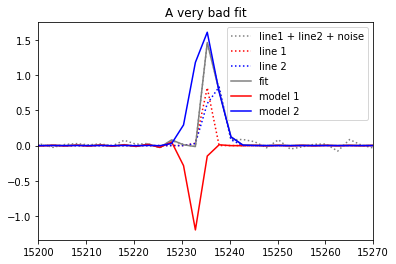

In [8]:
fit = orb.fit.fit_lines_in_spectrum(spectrum, [halpha_cm1, halpha_cm1], step, order, nm_laser, theta, 0, 
                                    wavenumber=True, apodization=1, fmodel='sincgauss',
                                    pos_def=['1', '2'],
                                    pos_cov=[velocity1, velocity2], 
                                    sigma_guess=[broadening1, broadening2])
print 'velocity (in km/s): ', fit['velocity_gvar']
print 'broadening (in km/s): ', fit['broadening_gvar']
print 'flux (in the unit of the spectrum amplitude / unit of the axis fwhm): ', fit['flux_gvar']
# independant plot of the two lines models and the real lines
pl.plot(spectrum_axis, spectrum, label='line1 + line2 + noise', ls=':', c='0.5')
pl.plot(spectrum_axis, spectrum1, label='line 1', ls=':', c='red')
pl.plot(spectrum_axis, spectrum2, label='line 2', ls=':', c='blue')
models = fit['fitted_models']['Cm1LinesModel']
pl.plot(spectrum_axis, fit['fitted_vector'], label='fit', ls='-', c='0.5')
pl.plot(spectrum_axis, models[0], label='model 1', ls='-', c='red')
pl.plot(spectrum_axis, models[1], label='model 2', ls='-', c='blue')
pl.xlim((15200, 15270))
pl.legend()
pl.title('A very bad fit')
pl.savefig('gvar_bad_fit.svg')

### Bayesian fit

Now let's say you have some informations on the broadening and the velocity of one or both of the unresolved lines e.g. there is some diffused ionized gas in the foreground which is everywhere in the field of view and you are interested into the point-like source emitting in H-alpha at a slightly different velocity. 

LSQFIT, a fitting module which integrates gaussian random variable as priors (initial guess) has been developed by  G. Peter Lepage (Cornell University) (see https://github.com/gplepage/lsqfit and http://pythonhosted.org/lsqfit/index.html). This module gives the perfect answer to this problem. We can now inject some more information and help the fitting algorithm to find a unique and better constrained best fit.

This algorithm has been implemented into ORCS. To use it you have to :

- guess the SNR of the lines (yes, this is not so easy, but you can try with one rough SNR, do the fitting, compute the real SNR from the residual and then fit again, the only thing that will change is the uncertainty on the parameters)
- define the initial guesses as random variables (we will use the package gvar which is intimatly linked to lsqfit - same author)

=== velocity ===
input velocity (km/s):  53(10) 7(10)
fitted velocity (km/s):  [40.6(3.6) 1.8(8.0)]
real velocity (km/s) 50 10
=== broadening ===
input broadening (km/s):  18(10) 27(10)
fitted broadening (km/s):  [18.000(29) 27.000(44)]
real broadening (km/s) 15 30
=== flux ===
flux (in the unit of the spectrum amplitude / unit of the axis fwhm):  [1.46(27) 1.11(28)]


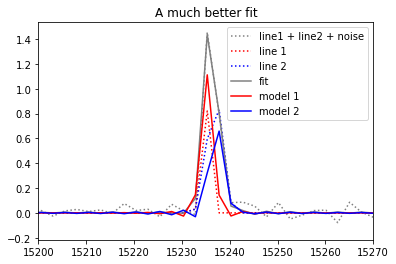

In [10]:
import gvar #  library used to define gaussian random variables
# now we can define our random variables, we are purposely biasing the inital guess 
# and giving a large error of +/- 10 km/s on both the velocity and the broadening

velocity1_gvar = gvar.gvar(velocity1+3, 10) # velocity1 is known at +/- 10 km/s
velocity2_gvar = gvar.gvar(velocity2-3, 10) # velocity2 is known at +/- 10 km/s
broadening1_gvar = gvar.gvar(broadening1+3, 10) # broadening1 is known at +/- 10 km/s
broadening2_gvar = gvar.gvar(broadening2-3, 10) # broadening2 is known at +/- 10 km/s

fit = orb.fit.fit_lines_in_spectrum(spectrum, [halpha_cm1, halpha_cm1], step, order, nm_laser, theta, 0, 
                                    wavenumber=True, apodization=1, fmodel='sincgauss',
                                    pos_def=['1', '2'],
                                    pos_cov=[velocity1_gvar, velocity2_gvar], 
                                    sigma_def='free',
                                    sigma_guess=[broadening1_gvar, broadening2_gvar],
                                    snr_guess=SNR)

print '=== velocity ==='
print 'input velocity (km/s): ', velocity1_gvar, velocity2_gvar
print 'fitted velocity (km/s): ', fit['velocity_gvar']
print 'real velocity (km/s)', velocity1, velocity2

print '=== broadening ==='
print 'input broadening (km/s): ', broadening1_gvar, broadening2_gvar
print 'fitted broadening (km/s): ', fit['broadening_gvar']
print 'real broadening (km/s)', broadening1, broadening2

print '=== flux ==='
print 'flux (in the unit of the spectrum amplitude / unit of the axis fwhm): ', fit['flux_gvar']
# independant plot of the two lines models and the real lines
pl.plot(spectrum_axis, spectrum, label='line1 + line2 + noise', ls=':', c='0.5')
pl.plot(spectrum_axis, spectrum1, label='line 1', ls=':', c='red')
pl.plot(spectrum_axis, spectrum2, label='line 2', ls=':', c='blue')
models = fit['fitted_models']['Cm1LinesModel']
pl.plot(spectrum_axis, fit['fitted_vector'], label='fit', ls='-', c='0.5')
pl.plot(spectrum_axis, models[0], label='model 1', ls='-', c='red')
pl.plot(spectrum_axis, models[1], label='model 2', ls='-', c='blue')
pl.xlim((15200, 15270))
pl.legend()
pl.title('A much better fit')
pl.savefig('gvar_good_fit.svg')